In [1]:
#  Imports
from src.parsers import HMParser
from src.resources import BinaryResource, Generator, Load, Storage, Vehicle
from src.scenes import HMProblemScene

import numpy as np
import matplotlib.pyplot as plt

# Ignore the warnings (only demonstration purposes!)
import warnings
warnings.filterwarnings("ignore")

2024-01-01 18:40:34,784	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
# Data parsing

data = HMParser(file_path='data/EC_V4.xlsx', ec_id=1)
data.parse()

In [3]:
# Define generators
gens = Generator(name='gens',
                 value=np.zeros(data.generator['p_forecast'].shape),
                 lower_bound=np.zeros(data.generator['p_forecast'].shape),
                 upper_bound=data.generator['p_forecast'],
                 cost=data.generator['cost_parameter_b'],
                 cost_nde=data.generator['cost_nde'],
                 is_renewable=data.generator['type_generator'])

# Define loads
loads = Load(name='loads',
             value=data.load['p_forecast'],
             lower_bound=np.zeros(data.load['p_forecast'].shape),
             upper_bound=data.load['p_forecast'],
             cost=np.ones(data.load['p_forecast'].shape),
             cost_cut=data.load['cost_cut'],
             cost_reduce=data.load['cost_reduce'],
             cost_ens=data.load['cost_ens'])

# Define storage
stor = Storage(name='stor',
               value=np.zeros(data.storage['p_charge_limit'].shape),
               lower_bound=np.zeros(data.storage['p_charge_limit'].shape),
               upper_bound=(data.storage['energy_capacity'] *
                            np.ones(data.storage['p_charge_limit'].shape).transpose()).transpose(),
               cost=np.ones(data.storage['p_charge_limit'].shape),
               cost_discharge=data.storage['discharge_price'],
               cost_charge=data.storage['charge_price'],
               capacity_max=data.storage['energy_capacity'],
               capacity_min=data.storage['energy_min_percentage'],
               initial_charge=data.storage['initial_state'],
               discharge_efficiency=data.storage['discharge_efficiency'],
               discharge_max=data.storage['p_discharge_limit'],
               charge_efficiency=data.storage['charge_efficiency'],
               charge_max=data.storage['p_charge_limit'],
               capital_cost=np.array([0.05250, 0.10500, 0.01575]))

# Define vehicle to grid
v2g = Vehicle(name='evs',
              value=np.zeros(data.vehicle['schedule_charge'].shape),
              lower_bound=(data.vehicle['e_capacity_max'] * data.vehicle['min_technical_soc'] *
                           np.ones(data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              upper_bound=(data.vehicle['e_capacity_max'] * np.ones(data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              cost=np.ones(data.vehicle['schedule_charge'].shape),
              cost_discharge=data.vehicle['discharge_price'][:, 0],
              cost_charge=data.vehicle['charge_price'][:, 0],
              capacity_max=data.vehicle['e_capacity_max'],
              initial_charge=np.ones(data.vehicle['schedule_charge'].shape) * 0.8,
              min_charge=data.vehicle['min_technical_soc'],
              discharge_efficiency=data.vehicle['discharge_efficiency'],
              charge_efficiency=data.vehicle['charge_efficiency'],
              capital_cost=np.array([0.042, 0.063, 0.042, 0.042, 0.063]),
              schedule_discharge=data.vehicle['schedule_discharge'],
              schedule_charge=data.vehicle['schedule_charge'])

# Define imports and exports
pimp = BinaryResource(name='pImp',
                      value=np.zeros(data.peers['import_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(data.peers['import_contracted_p_max'][0, :].shape),
                      upper_bound=data.peers['import_contracted_p_max'][0, :],
                      cost=data.peers['buy_price'][0, :],
                      is_active=np.zeros(data.peers['import_contracted_p_max'][0, :].shape))

pexp = BinaryResource(name='pExp',
                      value=np.zeros(data.peers['export_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(data.peers['export_contracted_p_max'][0, :].shape),
                      upper_bound=data.peers['export_contracted_p_max'][0, :],
                      cost=data.peers['sell_price'][0, :],
                      is_active=np.zeros(data.peers['export_contracted_p_max'][0, :].shape))

# Establish the components
ec_components = {'gen': gens,
                 'loads': loads,
                 'stor': stor,
                 'evs': v2g,
                 'pimp': pimp,
                 'pexp': pexp}

ec_components

{'gen': gens,
 'loads': loads,
 'stor': stor,
 'evs': evs,
 'pimp': pImp,
 'pexp': pExp}

In [21]:
# Create the scene

scene = HMProblemScene(name='EC1', data=ec_components, hm_parser=data, pop_size=100,
                       n_iter=10000, iter_tolerance=1000)
scene.initialize()
scene.run()

100%|██████████| 10000/10000 [45:55<00:00,  3.63it/s]


In [14]:
 # Check the population

scene.algo.population

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [15]:
scene.current_best

{'genActPower': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.50611339,  1.44112432,  3.33849086,  5.74197012,  7.56872316,
          8.73575918,  9.40484766,  9.35514765,  8.60762704,  7.43992067,
          5.62898065,  3.16400677,  1.32673001,  0.46185889,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,

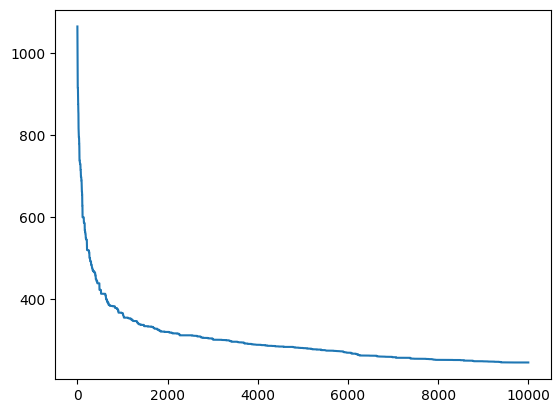

In [16]:
plt.plot(scene.algo.population_history_fitness)

In [17]:
scene.algo.population_history_fitness

[1064.9713687492974,
 1039.6126449189467,
 1039.6126449189467,
 999.2624433804596,
 973.5573247548591,
 935.7171668285857,
 914.8722118520107,
 914.8722118520107,
 914.8722118520107,
 914.8722118520107,
 914.8722118520107,
 914.8722118520107,
 913.5559036647396,
 901.4833427480457,
 891.3959904568275,
 890.9483350727238,
 876.6055745549469,
 876.6055745549469,
 876.6055745549469,
 857.98375226681,
 857.98375226681,
 857.98375226681,
 852.9078496785576,
 852.9078496785576,
 820.6523169608862,
 820.6523169608862,
 817.0106495642383,
 812.8111951112747,
 800.5650279607387,
 800.5650279607387,
 800.5650279607387,
 800.5650279607387,
 793.8322186661966,
 793.8322186661966,
 793.8322186661966,
 793.8322186661966,
 793.8322186661966,
 793.8322186661966,
 779.7943650661587,
 779.7943650661587,
 779.7943650661587,
 779.7943650661587,
 775.7864036525837,
 771.4560145113369,
 754.4828007309172,
 741.4448294050131,
 741.4448294050131,
 737.905174443307,
 737.905174443307,
 737.905174443307,
 737.9

In [18]:
scene.algo.population_fitness

[253.20982938607486,
 251.193589872891,
 246.01313370365412,
 255.71956923397633,
 253.86060711175162,
 250.5870645929288,
 253.14504796061286,
 250.43139076248414,
 251.38683782045652,
 253.50803748024367,
 251.2933616918317,
 254.78499635111407,
 256.4576506419686,
 245.57775206732518,
 253.22044258868587,
 248.8022519164122,
 248.30679577795556,
 246.73175434201397,
 250.93538123474963,
 251.177326918553,
 255.25699233029476,
 250.2344357075363,
 253.4058955811233,
 257.58327743386747,
 253.0835012167541,
 250.44290934378446,
 254.908519250218,
 252.7201725641869,
 251.76536373817837,
 248.58501988663426,
 253.2805346921878,
 245.46925303852117,
 259.0274139898839,
 247.74478468465531,
 249.212516582289,
 250.5131554740401,
 254.48190562953383,
 247.30622797035412,
 251.02250532788491,
 252.67374862320162,
 251.27594059584573,
 250.60921166872765,
 249.5365984810361,
 249.40841407581357,
 248.24459245275503,
 248.7696508201949,
 249.83461166357736,
 249.44179235469622,
 256.87306451

In [19]:
scene.current_best_fitness

247.66923369174998